In [ ]:
# this code uses a different feature extraction technique than the original code
# TF-IDF is used for feature extraction 

# Install required Packages and Libraries 

In [4]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer # lemmatizes word based on its parts of speech
from sklearn.metrics import roc_curve, classification_report, confusion_matrix 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Load the Datasets

In [5]:
#load ADMISSIONS dataset
admissions_data = pd.read_csv(r'C:\Users\pankt\Final_Year\ADMISSIONS.csv')


# Load the Datasets

In [6]:
# Exploring data in admissions table
admissions_data.shape

(58976, 19)

In [7]:
# to explore categories of ADMISSION_TYPE column
admissions_data['ADMISSION_TYPE'].value_counts()

EMERGENCY    42071
NEWBORN       7863
ELECTIVE      7706
URGENT        1336
Name: ADMISSION_TYPE, dtype: int64

In [8]:
# Remove New Born admissions from dataset
admissions_data = admissions_data.loc[admissions_data.ADMISSION_TYPE != 'NEWBORN']

In [9]:
# to explore categories of ADMISSION_TYPE column, to make sure NEWBORN is removed
admissions_data['ADMISSION_TYPE'].value_counts()

EMERGENCY    42071
ELECTIVE      7706
URGENT        1336
Name: ADMISSION_TYPE, dtype: int64

In [10]:
#to remove death admissions

hadm_rows_death = admissions_data.loc[admissions_data.DEATHTIME.notnull()]
print("total admissions died:", len(hadm_rows_death))

# store hadm_id for dead patients in a list
hadm_death_list = list(hadm_rows_death["HADM_ID"])

print("HADM_ID list total:", len(hadm_death_list))

total admissions died: 5792
HADM_ID list total: 5792


In [11]:
#remove death admissions
admissions_data = admissions_data.loc[admissions_data.DEATHTIME.isnull()]

In [12]:
# to ensure rows with specific deathtime are removed
print('shape of admission table:', admissions_data.shape)
print('total number of live admissions:', admissions_data.DEATHTIME.isnull().count())


shape of admission table: (45321, 19)
total number of live admissions: 45321


In [13]:
#convert date strings format to datetime format 

admissions_data.ADMITTIME = pd.to_datetime(admissions_data.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
admissions_data.DISCHTIME = pd.to_datetime(admissions_data.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
admissions_data.DEATHTIME = pd.to_datetime(admissions_data.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

#to count and check null dates fields
print('total null admissions dates:', admissions_data.ADMITTIME.isnull().count())
print('total null discharge dates:', admissions_data.DISCHTIME.isnull().count())

total null admissions dates: 45321
total null discharge dates: 45321


In [14]:
#to sort values according to subject_id and admittime
admissions_data = admissions_data.sort_values(['SUBJECT_ID','ADMITTIME'])
#drop is added to prevent old index used as column
#new sequential index is used by resetting the index
admissions_data = admissions_data.reset_index(drop = True)

In [15]:
#create next_admittime and next_admission type columns to calculate number of days gap between 2 admits
admissions_data['NEXT_ADMITTIME'] = admissions_data.groupby('SUBJECT_ID').ADMITTIME.shift(-1)

# to create a column that holds the 'next admission type' for each subject
admissions_data['NEXT_ADMISSION_TYPE'] = admissions_data.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)

In [16]:
#remove entries with next admission type as elective
#as we are considering only urgent and emergency next admit type to calculate readmissions
rows = admissions_data.NEXT_ADMISSION_TYPE == 'ELECTIVE'
admissions_data.loc[rows,'NEXT_ADMITTIME'] = pd.NaT
admissions_data.loc[rows,'NEXT_ADMISSION_TYPE'] = np.NaN

In [17]:
#again sort values according to subject id and admittime
admissions_data = admissions_data.sort_values(['SUBJECT_ID','ADMITTIME'])
# back fill data
admissions_data[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = admissions_data.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')

In [18]:
# calculate days between 2 consecutive admits
admissions_data['DAYS_BETWEEN_ADMITS'] = (admissions_data.NEXT_ADMITTIME - admissions_data.DISCHTIME).dt.total_seconds()/(24*60*60) 

In [19]:
#print HADM_ID list
len(list(admissions_data['HADM_ID']))

45321

In [20]:
#to count admissions category in next_admission_type column
admissions_data['NEXT_ADMISSION_TYPE'].value_counts()

EMERGENCY    9561
URGENT        144
Name: NEXT_ADMISSION_TYPE, dtype: int64

In [21]:
#count data in next_admission_type column
admissions_data['NEXT_ADMISSION_TYPE'].count()

9705

In [22]:
#to check count of null values under days_till_next_admit column
pd.isnull(admissions_data.DAYS_BETWEEN_ADMITS).value_counts()

True     35616
False     9705
Name: DAYS_BETWEEN_ADMITS, dtype: int64

In [23]:
#load NOTEEVENTS.csv
noteevents_data = pd.read_csv("NOTEEVENTS.csv")

C:\Users\pankt\anaconda_3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [24]:
#to check the lists where HADM_ID is null
sum(list(noteevents_data.HADM_ID.isnull()))

231836

In [25]:
#exploring noteevents dataset
noteevents_data.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [26]:
#to check with hadm_id list and remove death admissions 
noteevents_data = noteevents_data[~noteevents_data['HADM_ID'].isin(hadm_death_list)]
# print df_notes after removing deaths
noteevents_data.head()

,ROW_ID,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,STORETIME,CATEGORY,DESCRIPTION,CGID,ISERROR,TEXT
0,174,22532,167853.0,2151-08-04,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2151-7-16**] Dischar...
1,175,13702,107527.0,2118-06-14,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2118-6-2**] Discharg...
2,176,13702,167118.0,2119-05-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2119-5-4**] D...
3,177,13702,196489.0,2124-08-18,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2124-7-21**] ...
4,178,26880,135453.0,2162-03-25,NaN,NaN,Discharge summary,Report,NaN,NaN,Admission Date: [**2162-3-3**] D...


In [27]:
# print shape of noteevents data after deaths are removed
print('shape of data after deaths removed:', noteevents_data.shape)

shape of data after deaths removed: (1841968, 11)


In [28]:
#convert string format to date format
noteevents_data.CHARTDATE = pd.to_datetime(noteevents_data.CHARTDATE, format = '%Y-%m-%d', errors = 'coerce')
noteevents_data.CHARTTIME = pd.to_datetime(noteevents_data.CHARTTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')

In [29]:
# sort values and provide new index to noteevents data
noteevents_data = noteevents_data.sort_values(['SUBJECT_ID','CHARTDATE', 'CHARTTIME'])
noteevents_data = noteevents_data.reset_index(drop = True)

In [30]:
# explore noteevents data after removing unwanted columns
noteevents_data[['SUBJECT_ID', 'HADM_ID', 'CHARTDATE', 'CHARTTIME', 'TEXT']].head()

,SUBJECT_ID,HADM_ID,CHARTDATE,CHARTTIME,TEXT
0,2,163353.0,2138-07-17,2138-07-17 22:51:00,Neonatology Attending Triage Note\n\nBaby [**N...
1,2,163353.0,2138-07-17,2138-07-17 23:08:00,Nursing Transfer note\n\n\nPt admitted to NICU...
2,3,NaN,2101-10-06,2101-10-06 18:02:00,[**2101-10-6**] 6:02 PM\n CHEST (PORTABLE AP) ...
3,3,NaN,2101-10-06,NaT,Sinus rhythm\nInferior/lateral ST-T changes ar...
4,3,NaN,2101-10-11,2101-10-11 21:06:00,[**2101-10-11**] 9:06 PM\n CHEST (PRE-OP PA & ...


In [31]:
# filter the data for DISHCHARGE SUMMARIES for further prediction
notes_discharge_summary = noteevents_data.loc[noteevents_data.CATEGORY == 'Discharge summary']

In [32]:
# consider only one admission entry per HADM_ID
notes_discharge_summary_unique = (notes_discharge_summary.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()
assert notes_discharge_summary_unique.duplicated(['HADM_ID']).sum() == 0, 'Multiple discharge summaries per admission'

# Merge ADMISSIONS and NOTEEVENTS datasets

In [33]:
# merge 2 datasets and prepare data for further steps 
adm_notes_data = pd.merge(admissions_data[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME','DAYS_BETWEEN_ADMITS','NEXT_ADMITTIME','ADMISSION_TYPE','DEATHTIME']],
                        notes_discharge_summary_unique[['SUBJECT_ID','HADM_ID','TEXT']], 
                        on = ['SUBJECT_ID','HADM_ID'],
                        how = 'left')
assert len(admissions_data) == len(adm_notes_data), 'Number of rows increased'

In [34]:
#groupby the data according to admission_type column
adm_notes_data.groupby('ADMISSION_TYPE').apply(lambda g: g.TEXT.isnull().sum())/adm_notes_data.groupby('ADMISSION_TYPE').size()

ADMISSION_TYPE
ELECTIVE     0.048076
EMERGENCY    0.028550
URGENT       0.028936
dtype: float64

In [35]:
# create output_label based on readmissions done within 30 days of discharge
adm_notes_data['OUTPUT_LABEL'] = (adm_notes_data.DAYS_BETWEEN_ADMITS < 30).astype('int')

In [36]:
#showcase the merged dataset
print(adm_notes_data.head())

   SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
0           3   145834 2101-10-20 19:08:00 2101-10-31 13:58:00   
1           4   185777 2191-03-16 00:28:00 2191-03-23 18:41:00   
2           6   107064 2175-05-30 07:15:00 2175-06-15 16:00:00   
3          11   194540 2178-04-16 06:18:00 2178-05-11 19:00:00   
4          13   143045 2167-01-08 18:43:00 2167-01-15 15:15:00   

   DAYS_BETWEEN_ADMITS NEXT_ADMITTIME ADMISSION_TYPE DEATHTIME  \
0                  NaN            NaT      EMERGENCY       NaT   
1                  NaN            NaT      EMERGENCY       NaT   
2                  NaN            NaT       ELECTIVE       NaT   
3                  NaN            NaT      EMERGENCY       NaT   
4                  NaN            NaT      EMERGENCY       NaT   

                                                TEXT  OUTPUT_LABEL  
0  Admission Date:  [**2101-10-20**]     Discharg...             0  
1  Admission Date:  [**2191-3-16**]     Discharge...             0  

In [37]:
#print shape of merged data
adm_notes_data.shape

(45321, 10)

In [38]:
# check if all the entries under DEATHTIME column is NULL
adm_notes_data['DEATHTIME']

0       NaT
1       NaT
2       NaT
3       NaT
4       NaT
         ..
45316   NaT
45317   NaT
45318   NaT
45319   NaT
45320   NaT
Name: DEATHTIME, Length: 45321, dtype: datetime64[ns]

In [39]:
# drop unwanted deathtime column
adm_notes_data.drop('DEATHTIME',inplace=True, axis=1)

In [40]:
# to check how many readmissions were under 30 days, 1 represents readmissions were under 30 days
print(adm_notes_data['OUTPUT_LABEL'].value_counts())

0    42772
1     2549
Name: OUTPUT_LABEL, dtype: int64


In [41]:
# dimension of merged dataset
adm_notes_data.shape

(45321, 9)

In [42]:
# remove OUTPUT_LABEL for further breaking of dataset
adm_notes_data.iloc[:,:-1]

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DAYS_BETWEEN_ADMITS,NEXT_ADMITTIME,ADMISSION_TYPE,TEXT
0,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,NaT,EMERGENCY,Admission Date: [**2101-10-20**] Discharg...
1,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,NaT,EMERGENCY,Admission Date: [**2191-3-16**] Discharge...
2,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaN,NaT,ELECTIVE,Admission Date: [**2175-5-30**] Dischar...
3,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaN,NaT,EMERGENCY,Admission Date: [**2178-4-16**] ...
4,13,143045,2167-01-08 18:43:00,2167-01-15 15:15:00,NaN,NaT,EMERGENCY,"Name: [**Known lastname 9900**], [**Known fir..."
...,...,...,...,...,...,...,...,...
45316,99985,176670,2181-01-27 02:47:00,2181-02-12 17:05:00,NaN,NaT,EMERGENCY,Admission Date: [**2181-1-27**] ...
45317,99991,151118,2184-12-24 08:30:00,2185-01-05 12:15:00,NaN,NaT,ELECTIVE,Admission Date: [**2184-12-24**] ...
45318,99992,197084,2144-07-25 18:03:00,2144-07-28 17:56:00,NaN,NaT,EMERGENCY,Admission Date: [**2144-7-25**] ...
45319,99995,137810,2147-02-08 08:00:00,2147-02-11 13:15:00,NaN,NaT,ELECTIVE,Admission Date: [**2147-2-8**] D...


In [43]:
# print no of positive and negative samples
print('Number of positive samples:', (adm_notes_data.OUTPUT_LABEL == 1).sum())
print('Number of negative samples:',  (adm_notes_data.OUTPUT_LABEL == 0).sum())
print('Total samples:', len(adm_notes_data))

Number of positive samples: 2549
Number of negative samples: 42772
Total samples: 45321


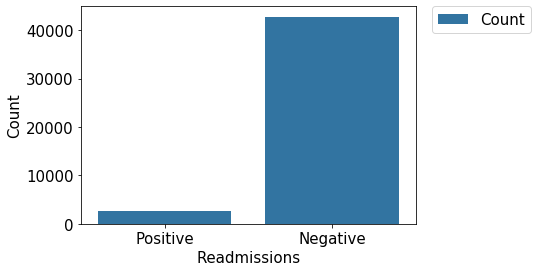

In [115]:
# compare base models 
df_results_data = pd.DataFrame({'Number of Readmissions':['Positive',
                                         'Negative'],
                        
                           'data_set':['Count', 'Count'],
                
                          'Count':[(adm_notes_data.OUTPUT_LABEL == 1).sum(),
                                      (adm_notes_data.OUTPUT_LABEL == 0).sum(),]
                          })

# showcase results in form of table
df_results_data

#create a histogram of the output
ax = sns.barplot(x="Number of Readmissions", y="Count",hue = "data_set", data=df_results_data)
ax.set_xlabel('Readmissions',fontsize = 15)
ax.set_ylabel('Count', fontsize = 15)
ax.tick_params(labelsize=15)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

In [44]:
# split data in form of X and y
X = adm_notes_data.iloc[:,:-1]
y = adm_notes_data['OUTPUT_LABEL']

In [45]:
# shuffle data 
# split data in train and test set
adm_notes_data = adm_notes_data.sample(n = len(adm_notes_data), random_state = 72)
adm_notes_data = adm_notes_data.reset_index(drop = True)

from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [46]:
# print x and y data dimension 
print("X:" ,X.head())
print("Y:" ,y.head())
print("X: " , X.shape)
print("Y: ", y.shape)

X:    SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
0           3   145834 2101-10-20 19:08:00 2101-10-31 13:58:00   
1           4   185777 2191-03-16 00:28:00 2191-03-23 18:41:00   
2           6   107064 2175-05-30 07:15:00 2175-06-15 16:00:00   
3          11   194540 2178-04-16 06:18:00 2178-05-11 19:00:00   
4          13   143045 2167-01-08 18:43:00 2167-01-15 15:15:00   

   DAYS_BETWEEN_ADMITS NEXT_ADMITTIME ADMISSION_TYPE  \
0                  NaN            NaT      EMERGENCY   
1                  NaN            NaT      EMERGENCY   
2                  NaN            NaT       ELECTIVE   
3                  NaN            NaT      EMERGENCY   
4                  NaN            NaT      EMERGENCY   

                                                TEXT  
0  Admission Date:  [**2101-10-20**]     Discharg...  
1  Admission Date:  [**2191-3-16**]     Discharge...  
2  Admission Date: [**2175-5-30**]        Dischar...  
3  Admission Date:  [**2178-4-16**]        

In [47]:
# remove data imbalance, by downsampling data
from sklearn.utils import resample
sampl_temp = pd.concat([X_train,y_train],axis=1)

# Separate majority and minority classes
df_majority = sampl_temp[sampl_temp.OUTPUT_LABEL==0]
df_minority = sampl_temp[sampl_temp.OUTPUT_LABEL==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=1805,     # to match minority class
                                 random_state=72) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.OUTPUT_LABEL.value_counts()

1    1810
0    1805
Name: OUTPUT_LABEL, dtype: int64

In [49]:
# analyse samples of downsampled data
print(df_downsampled.shape)
print(type(df_downsampled))
print(df_downsampled.head())

(3615, 9)
<class 'pandas.core.frame.DataFrame'>
       SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
24064       28128   104705 2146-05-09 12:37:00 2146-05-15 13:30:00   
25127       29335   105820 2185-05-06 00:39:00 2185-05-25 14:05:00   
2862         3404   116930 2162-01-31 10:59:00 2162-02-12 17:25:00   
31029       50404   110630 2110-09-21 22:40:00 2110-10-25 15:48:00   
36910       70571   115921 2159-03-19 18:42:00 2159-03-24 13:15:00   

       DAYS_BETWEEN_ADMITS NEXT_ADMITTIME ADMISSION_TYPE  \
24064                  NaN            NaT      EMERGENCY   
25127                  NaN            NaT      EMERGENCY   
2862                   NaN            NaT      EMERGENCY   
31029                  NaN            NaT      EMERGENCY   
36910                  NaN            NaT      EMERGENCY   

                                                    TEXT  OUTPUT_LABEL  
24064  Admission Date:  [**2146-5-9**]              D...             0  
25127  Admission Date:  

In [50]:
# pos tagging
def convert_tag(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'
    elif treebank_tag.startswith('V'):
        return 'v'
    elif treebank_tag.startswith('N'):
        return 'n'
    elif treebank_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

In [51]:
#lemmatization
def lemmatizer(tokens):
    tagged_words = pos_tag(tokens)
    wnl = WordNetLemmatizer()
    
    lemma_words = []
    for tupl in tagged_words:
        lemma_words.append(wnl.lemmatize(tupl[0], convert_tag(tupl[1])))
    
    return lemma_words

In [52]:
#data preprocessing 
def preprocessing(text):
    
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\r', '', text)
    word_tokens = word_tokenize(text) 
    tokens = [word for word in word_tokens if word not in stopwords.words('english')]
    lemmatized_tokens = lemmatizer(tokens)
    return lemmatized_tokens

In [53]:
# implementing TF-IDF, feature extraction tool 
vectorized_text = TfidfVectorizer(max_features=10000, tokenizer=preprocessing)
vectorized = vectorized_text.fit_transform(df_downsampled.TEXT.values.astype(str))
pd.DataFrame(vectorized.toarray(), 
             index=['sentence '+str(i) 
                    for i in range(1, 1+len(df_downsampled.TEXT.values.astype(str)))],
             columns=vectorized_text.get_feature_names())

,aa,aaa,aao,ab,abaseline,abcess,abd,abdomen,abdomenpelvis,abdominal,...,zocor,zofran,zoloft,zolpidem,zone,zonisamide,zoster,zosyn,zygomatic,zyprexa
sentence 1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
sentence 2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.014924,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
sentence 3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.045918,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
sentence 4,0.0,0.0,0.0,0.0,0.0,0.0,0.020251,0.030854,0.0,0.021522,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.079487,0.0,0.0
sentence 5,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sentence 3611,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
sentence 3612,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
sentence 3613,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
sentence 3614,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.026092,0.0,0.072799,...,0.0,0.0,0.057927,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [54]:
# create test data
temp_test = pd.concat([X_test,y_test],axis=1)

In [55]:
# print dimensions of test samples
print(type(temp_test))
print(temp_test.shape)
print(temp_test.head())

<class 'pandas.core.frame.DataFrame'>
(13597, 9)
       SUBJECT_ID  HADM_ID           ADMITTIME           DISCHTIME  \
3530         4161   181120 2109-03-02 00:32:00 2109-03-06 17:01:00   
25856       30091   126085 2144-07-31 11:30:00 2144-08-10 15:15:00   
21419       25196   195924 2145-12-17 23:20:00 2146-01-01 12:15:00   
4365         5158   197887 2167-06-27 12:57:00 2167-07-06 19:00:00   
21743       25549   139656 2175-03-08 12:00:00 2175-03-27 17:50:00   

       DAYS_BETWEEN_ADMITS NEXT_ADMITTIME ADMISSION_TYPE  \
3530                   NaN            NaT      EMERGENCY   
25856                  NaN            NaT      EMERGENCY   
21419                  NaN            NaT      EMERGENCY   
4365                   NaN            NaT      EMERGENCY   
21743                  NaN            NaT       ELECTIVE   

                                                    TEXT  OUTPUT_LABEL  
3530   Admission Date:  [**2109-3-1**]       Discharg...             0  
25856  Admission Date: 

In [56]:
# count of positive and negative samples in test data
print(temp_test.OUTPUT_LABEL.value_counts())

0    12858
1      739
Name: OUTPUT_LABEL, dtype: int64


In [57]:
# to transform the data into vector format
X_train_tf = vectorized_text.transform(df_downsampled.TEXT.values.astype(str))
X_test_tf = vectorized_text.transform(temp_test.TEXT.values.astype(str))

In [58]:
# provide label to test, valid, and train data
y_train_tf = df_downsampled.OUTPUT_LABEL
y_test_tf = temp_test.OUTPUT_LABEL

In [59]:
# create evaluation metrics
def showResults(modelname,test, pred):
    accuracy = accuracy_score(test, pred)
    precision=precision_score(test, pred, average='weighted')
    f1Score=f1_score(test, pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("F1Score : {}".format(f1Score))
    print("Confusion Matrix: ")
    print(confusion_matrix(test, pred))
    print("Classification Report: ")
    print(classification_report(test, pred))
    results = accuracy
    return results

In [60]:
# implement KNN
temp_knn = KNeighborsClassifier(n_neighbors=100)
temp_knn.fit(X_train_tf, y_train_tf)

base_knn_predictions=temp_knn.predict(X_test_tf)
print("Base KNN Model Performance:")
knn_base_results = showResults("Base KNN",y_test_tf, base_knn_predictions)

Base KNN Model Performance:
Accuracy  : 0.4520850187541369
Precision : 0.9184283784830183
F1Score : 0.5747972255495682
Confusion Matrix: 
[[5598 7260]
 [ 190  549]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.44      0.60     12858
           1       0.07      0.74      0.13       739

    accuracy                           0.45     13597
   macro avg       0.52      0.59      0.36     13597
weighted avg       0.92      0.45      0.57     13597



In [62]:
#implement gridsearch in knn
#create a dictionary of all values we want to test for n_neighbors
param_grid = {"n_neighbors": [400, 500, 600, 700]}
#use gridsearch to test all values for n_neighbors
grid_knn = GridSearchCV(temp_knn, param_grid, cv=3)
#fit model to data
grid_knn.fit(X_train_tf, y_train_tf)

GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=100, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [400, 500, 600, 700]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [63]:
#result of gridsearch knn 
grid_knn_predictions=grid_knn.predict(X_test_tf)
print("Grid KNN Model Performance:")
grid_knn_results = showResults("GridSearchCV KNN",y_test_tf, grid_knn_predictions)

Grid KNN Model Performance:
Accuracy  : 0.38346694123703756
Precision : 0.9212968482018956
F1Score : 0.5023998696593996
Confusion Matrix: 
[[4616 8242]
 [ 141  598]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.36      0.52     12858
           1       0.07      0.81      0.12       739

    accuracy                           0.38     13597
   macro avg       0.52      0.58      0.32     13597
weighted avg       0.92      0.38      0.50     13597



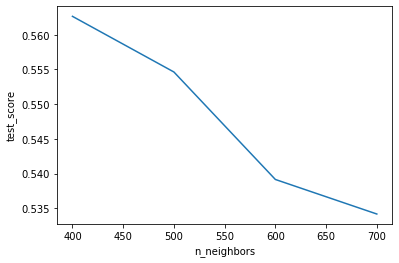

In [64]:
#graph plotting n_neighbours and test score
grid_knn_scores_df = pd.DataFrame(grid_knn.cv_results_['params'])
grid_knn_scores_df['test_score'] = grid_knn.cv_results_['mean_test_score']
ax = sns.lineplot(x="n_neighbors", y="test_score", data=grid_knn_scores_df)
figure=ax.get_figure()

In [68]:
#implement random searchcv in knn
random_knn = RandomizedSearchCV(temp_knn, param_grid, cv=10, scoring='accuracy', n_iter=10, random_state=5)
random_knn.fit(X_train_tf, y_train_tf)

print(random_knn.best_score_)
print(random_knn.best_params_)

random_knn_predictions=random_knn.predict(X_test_tf)
print("Random Search KNN Model Performance:")
random_knn_results = showResults("RandomSearchCV KNN",y_test_tf, random_knn_predictions)

C:\Users\pankt\anaconda_3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


0.5654405350392556
{'n_neighbors': 400}
Random Search KNN Model Performance:
Accuracy  : 0.38346694123703756
Precision : 0.9212968482018956
F1Score : 0.5023998696593996
Confusion Matrix: 
[[4616 8242]
 [ 141  598]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.36      0.52     12858
           1       0.07      0.81      0.12       739

    accuracy                           0.38     13597
   macro avg       0.52      0.58      0.32     13597
weighted avg       0.92      0.38      0.50     13597



In [70]:
print("Base KNN Model\n")
showResults("Base KNN",y_test_tf, base_knn_predictions)

print("\nGridSearchCV KNN Model\n")
grid_knn_results = showResults("GridSearchCV KNN",y_test_tf, grid_knn_predictions)

Base KNN Model

Accuracy  : 0.4520850187541369
Precision : 0.9184283784830183
F1Score : 0.5747972255495682
Confusion Matrix: 
[[5598 7260]
 [ 190  549]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.44      0.60     12858
           1       0.07      0.74      0.13       739

    accuracy                           0.45     13597
   macro avg       0.52      0.59      0.36     13597
weighted avg       0.92      0.45      0.57     13597


GridSearchCV KNN Model

Accuracy  : 0.38346694123703756
Precision : 0.9212968482018956
F1Score : 0.5023998696593996
Confusion Matrix: 
[[4616 8242]
 [ 141  598]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.36      0.52     12858
           1       0.07      0.81      0.12       739

    accuracy                           0.38     13597
   macro avg       0.52      0.58      0.32     13597
weighted avg       0.92      0.38    

In [71]:
#implement random forest classifier 
base_rf = RandomForestClassifier(n_estimators = 700, random_state = 72, max_depth=150, max_features="auto")
base_rf.fit(X_train_tf, y_train_tf)


base_rf_predictions=base_rf.predict(X_test_tf)
#print(base_rf_predictions.shape)

base_rf_results = showResults("Base RF",y_test_tf, base_rf_predictions)

#scores = cross_val_score(base_rf, X_train_tf, y_train_tf, cv=10, scoring='accuracy')
#print("Mean Cross-validation score = ", np.mean(scores))

Accuracy  : 0.6277119952930793
Precision : 0.9203243429099409
F1Score : 0.7282621877453038
Confusion Matrix: 
[[8062 4796]
 [ 266  473]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.63      0.76     12858
           1       0.09      0.64      0.16       739

    accuracy                           0.63     13597
   macro avg       0.53      0.63      0.46     13597
weighted avg       0.92      0.63      0.73     13597



In [72]:
# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]# number of features at every split
max_features = ["auto", "sqrt"]

# max depth
max_depth = [int(x) for x in np.linspace(20, 300, num = 10)]
max_depth.append(None)

# create random grid
random_grid = {
 "n_estimators": n_estimators,
 "max_features": max_features,
 "max_depth": max_depth}

# Random search of parameters
random_rf = RandomizedSearchCV(estimator = base_rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=72, n_jobs = -1)# Fit the model
random_rf.fit(X_train_tf, y_train_tf)

# print results
print("Best Parameters are")
print(random_rf.best_params_)
print("Best Score is")
print(random_rf.best_score_)

best_random=random_rf.best_estimator_
random_rf_predictions = best_random.predict(X_test_tf)

random_rf_results = showResults("RandomSearchCV RF",y_test_tf, random_rf_predictions)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 14.2min finished


Best Parameters are
{'n_estimators': 1000, 'max_features': 'sqrt', 'max_depth': 51}
Best Score is
0.6301521438450899
Accuracy  : 0.6267559020372141
Precision : 0.921185738327164
F1Score : 0.727474361597794
Confusion Matrix: 
[[8041 4817]
 [ 258  481]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.63      0.76     12858
           1       0.09      0.65      0.16       739

    accuracy                           0.63     13597
   macro avg       0.53      0.64      0.46     13597
weighted avg       0.92      0.63      0.73     13597



In [75]:
#showcase the results 
print("Base Random Forest Model\n")
showResults("Base RF",y_test_tf, base_rf_predictions)

print("\nRandomSearchCV Model\n")
random_rf_results = showResults("RandomSearchCV RF",y_test_tf, random_rf_predictions)


Base Random Forest Model

Accuracy  : 0.6277119952930793
Precision : 0.9203243429099409
F1Score : 0.7282621877453038
Confusion Matrix: 
[[8062 4796]
 [ 266  473]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.63      0.76     12858
           1       0.09      0.64      0.16       739

    accuracy                           0.63     13597
   macro avg       0.53      0.63      0.46     13597
weighted avg       0.92      0.63      0.73     13597


RandomSearchCV Model

Accuracy  : 0.6267559020372141
Precision : 0.921185738327164
F1Score : 0.727474361597794
Confusion Matrix: 
[[8041 4817]
 [ 258  481]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.63      0.76     12858
           1       0.09      0.65      0.16       739

    accuracy                           0.63     13597
   macro avg       0.53      0.64      0.46     13597
weighted avg       0.92      0.6

In [76]:
#execute logistic regression
lr=LogisticRegression(random_state = 72)
lr.fit(X_train_tf, y_train_tf)

base_lr_predictions=lr.predict(X_test_tf)

base_lr_results = showResults("Base LR",y_test_tf, base_lr_predictions)

Accuracy  : 0.6553651540781055
Precision : 0.9221150437000989
F1Score : 0.749260883950376
Confusion Matrix: 
[[8437 4421]
 [ 265  474]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.66      0.78     12858
           1       0.10      0.64      0.17       739

    accuracy                           0.66     13597
   macro avg       0.53      0.65      0.48     13597
weighted avg       0.92      0.66      0.75     13597



In [78]:
#gridsearch in LR
#create a dictionary of all values we want to test for n_neighbors
param_grid = { 'C': [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0],
    'penalty': ['l2'],
    'n_jobs': [-1]}
#use gridsearch to test all values for n_neighbors
grid_lr = GridSearchCV(lr, param_grid, cv=3)
#fit model to data
grid_lr.fit(X_train_tf, y_train_tf)
print("Best Parameters are")
print(grid_lr.best_params_)
print("Best Score is")
print(grid_lr.best_score_)

best_grid_lr=grid_lr.best_estimator_
grid_lr_predictions = best_grid_lr.predict(X_test_tf)
print(grid_lr_predictions.shape)

grid_lr_results = showResults("GridSearchCV LR",y_test_tf, grid_lr_predictions)

Best Parameters are
{'C': 1.0, 'n_jobs': -1, 'penalty': 'l2'}
Best Score is
0.6345781466113416
(13597,)
Accuracy  : 0.6553651540781055
Precision : 0.9221150437000989
F1Score : 0.749260883950376
Confusion Matrix: 
[[8437 4421]
 [ 265  474]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.66      0.78     12858
           1       0.10      0.64      0.17       739

    accuracy                           0.66     13597
   macro avg       0.53      0.65      0.48     13597
weighted avg       0.92      0.66      0.75     13597



In [80]:
#random search in LR
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter distribution using uniform distribution
#C = uniform(loc=0, scale=4)

# Create hyperparameter options
hyperparameters = dict(penalty=penalty)

random_lr = RandomizedSearchCV(lr, hyperparameters, random_state=72, n_iter=100, cv=5, verbose=0, n_jobs=-1)
lr_random_model = random_lr.fit(X_train_tf, y_train_tf)

base_lr_predictions=lr.predict(X_test_tf)

base_lr_results = showResults("Base LR",y_test_tf, base_lr_predictions)

# View best hyperparameters
print('Best Penalty:', lr_random_model.best_estimator_.get_params()['penalty'])
print('Best C:', lr_random_model.best_estimator_.get_params()['C'])

lr_random_model.predict(X_test_tf)


C:\Users\pankt\anaconda_3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Accuracy  : 0.6553651540781055
Precision : 0.9221150437000989
F1Score : 0.749260883950376
Confusion Matrix: 
[[8437 4421]
 [ 265  474]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.66      0.78     12858
           1       0.10      0.64      0.17       739

    accuracy                           0.66     13597
   macro avg       0.53      0.65      0.48     13597
weighted avg       0.92      0.66      0.75     13597

Best Penalty: l2
Best C: 1.0


array([0, 1, 0, ..., 1, 0, 1])

In [81]:
print("Base LR Model\n")
showResults("Base LR",y_test_tf, base_lr_predictions)
print("GridSearchCV LR Model\n")

showResults("GridSearchCV LR",y_test_tf, grid_lr_predictions)

Base LR Model

Accuracy  : 0.6553651540781055
Precision : 0.9221150437000989
F1Score : 0.749260883950376
Confusion Matrix: 
[[8437 4421]
 [ 265  474]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.66      0.78     12858
           1       0.10      0.64      0.17       739

    accuracy                           0.66     13597
   macro avg       0.53      0.65      0.48     13597
weighted avg       0.92      0.66      0.75     13597

GridSearchCV LR Model

Accuracy  : 0.6553651540781055
Precision : 0.9221150437000989
F1Score : 0.749260883950376
Confusion Matrix: 
[[8437 4421]
 [ 265  474]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.66      0.78     12858
           1       0.10      0.64      0.17       739

    accuracy                           0.66     13597
   macro avg       0.53      0.65      0.48     13597
weighted avg       0.92      0.66      0.75

0.6553651540781055

In [82]:
#implement SGDC
sgdc=SGDClassifier(loss = 'log',alpha = 0.1,random_state = 72)
sgdc.fit(X_train_tf, y_train_tf)

base_sgdc_predictions=sgdc.predict(X_test_tf)
sgdc_base_results = showResults("Base SGDC",y_test_tf, base_sgdc_predictions)

Accuracy  : 0.17400897256747813
Precision : 0.9266856268701928
F1Score : 0.22248031530853254
Confusion Matrix: 
[[ 1667 11191]
 [   40   699]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.98      0.13      0.23     12858
           1       0.06      0.95      0.11       739

    accuracy                           0.17     13597
   macro avg       0.52      0.54      0.17     13597
weighted avg       0.93      0.17      0.22     13597



In [84]:
#randomsearch cv in sgdc model
penalty = ['none','l2','l1']
max_iter = range(1000,5000,10000)
alpha = [0.001,0.003,0.01,0.03,0.1,0.3]
random_grid_sgdc = {'penalty':penalty,
              'max_iter':max_iter,
              'alpha':alpha}
# create the randomized search cross-validation
sgdc_random = RandomizedSearchCV(estimator = sgdc, param_distributions = random_grid_sgdc, 
                                 n_iter = 1000, cv = 2,verbose = 0, 
                                 random_state = 72)

sgdc_random.fit(X_train_tf, y_train_tf)

random_sgdc_predictions = sgdc_random.predict(X_test_tf)

sgdc_random_results = showResults("RandomSearchCV SGDC",y_test_tf, random_sgdc_predictions)


C:\Users\pankt\anaconda_3\lib\site-packages\sklearn\model_selection\_search.py:281: UserWarning: The total space of parameters 18 is smaller than n_iter=1000. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Accuracy  : 0.6352871957049349
Precision : 0.9211318587646928
F1Score : 0.7340640787794409
Confusion Matrix: 
[[8162 4696]
 [ 263  476]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.63      0.77     12858
           1       0.09      0.64      0.16       739

    accuracy                           0.64     13597
   macro avg       0.53      0.64      0.46     13597
weighted avg       0.92      0.64      0.73     13597



In [85]:
#gridsearch cv in sgdc model
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'loss': ['log'], # logistic regression,
    'penalty': ['l2'],
    'n_jobs': [-1]}
#use gridsearch to test all values for n_neighbors
grid_sgdc = GridSearchCV(sgdc, param_grid, cv=3)
#fit model to data
grid_sgdc.fit(X_train_tf, y_train_tf)
print("Best Parameters are")
print(grid_sgdc.best_params_)
print("Best Score is")
print(grid_sgdc.best_score_)

best_grid_sgdc=grid_sgdc.best_estimator_
grid_sgdc_predictions = best_grid_sgdc.predict(X_test_tf)
print(grid_sgdc_predictions.shape)
sgdc_grid_results = showResults("GridSearchCV SGDC",y_test_tf, grid_sgdc_predictions)


Best Parameters are
{'alpha': 0.001, 'loss': 'log', 'n_jobs': -1, 'penalty': 'l2'}
Best Score is
0.6232365145228216
(13597,)
Accuracy  : 0.6352871957049349
Precision : 0.9211318587646928
F1Score : 0.7340640787794409
Confusion Matrix: 
[[8162 4696]
 [ 263  476]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.63      0.77     12858
           1       0.09      0.64      0.16       739

    accuracy                           0.64     13597
   macro avg       0.53      0.64      0.46     13597
weighted avg       0.92      0.64      0.73     13597



In [86]:
# print results
print("Base SGDC Model\n")
showResults("Base SGDC",y_test_tf, base_rf_predictions)
#base_rf_cv_score = cross_val_score(base_rf, tempX, tempY, cv=10, scoring="roc_auc")


print("\nRandomSearchSGDC Model\n")
showResults("nRandomSearchSGDC",y_test_tf, random_sgdc_predictions)
#random_rf_cv_score = cross_val_score(best_random, X, y, cv=10, scoring="roc_auc")
showResults("GridSearchCV_SGDC",y_test_tf, grid_sgdc_predictions)

Base SGDC Model

Accuracy  : 0.6277119952930793
Precision : 0.9203243429099409
F1Score : 0.7282621877453038
Confusion Matrix: 
[[8062 4796]
 [ 266  473]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.63      0.76     12858
           1       0.09      0.64      0.16       739

    accuracy                           0.63     13597
   macro avg       0.53      0.63      0.46     13597
weighted avg       0.92      0.63      0.73     13597


RandomSearchSGDC Model

Accuracy  : 0.6352871957049349
Precision : 0.9211318587646928
F1Score : 0.7340640787794409
Confusion Matrix: 
[[8162 4696]
 [ 263  476]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.63      0.77     12858
           1       0.09      0.64      0.16       739

    accuracy                           0.64     13597
   macro avg       0.53      0.64      0.46     13597
weighted avg       0.92      0.64    

0.6352871957049349

In [87]:
#implement decision tree algorithm
tree = DecisionTreeClassifier(max_depth = 150, random_state = 72)
tree.fit(X_train_tf, y_train_tf)

base_tree_predictions = tree.predict(X_test_tf)
tree_base_results = showResults("Base Decision Tree",y_test_tf, base_tree_predictions)

Accuracy  : 0.5550489078473193
Precision : 0.9058940086666825
F1Score : 0.6708296251435691
Confusion Matrix: 
[[7151 5707]
 [ 343  396]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.56      0.70     12858
           1       0.06      0.54      0.12       739

    accuracy                           0.56     13597
   macro avg       0.51      0.55      0.41     13597
weighted avg       0.91      0.56      0.67     13597



In [88]:
#implement gradient boosting algorithm
gbc =GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
     max_depth=5, random_state=72)
gbc.fit(X_train_tf, y_train_tf)

base_gbc_predictions=gbc.predict(X_test_tf)
gbc_base_results = showResults("Base GBC",y_test_tf, base_gbc_predictions)

Accuracy  : 0.6394792969037287
Precision : 0.9186807786103061
F1Score : 0.7373749614573079
Confusion Matrix: 
[[8243 4615]
 [ 287  452]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.64      0.77     12858
           1       0.09      0.61      0.16       739

    accuracy                           0.64     13597
   macro avg       0.53      0.63      0.46     13597
weighted avg       0.92      0.64      0.74     13597



In [72]:
#implement random search CV with GBC model
n_estimators = range(100,500,100)

# maximum depth of the tree
max_depth = range(1,5,1)

# learning rate
learning_rate = [0.001,0.01,0.1]

# random grid

random_grid_gbc = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'learning_rate':learning_rate}

# create the randomized search cross-validation
gbc_random = RandomizedSearchCV(estimator = gbc, param_distributions = random_grid_gbc,
                                n_iter = 20, cv = 2, 
                                verbose = 0, random_state = 72)

gbc_random.fit(X_train_tf, y_train_tf)

random_gbc_predictions = gbc_random.predict(X_test_tf)

gbc_random_results = showResults("RandomSearchCV GBC",y_test_tf, random_gbc_predictions)

Accuracy  : 0.6545561520923733
Precision : 0.9168302510040194
F1Score : 0.7477949001944788
Confusion Matrix: 
[[8443 4395]
 [ 302  457]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.66      0.78     12838
           1       0.09      0.60      0.16       759

    accuracy                           0.65     13597
   macro avg       0.53      0.63      0.47     13597
weighted avg       0.92      0.65      0.75     13597



In [90]:
# implement grid search CV with gbc model
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'learning_rate':[0.01, 0.05, 0.1, 0.5, 1], 
              'min_samples_split':[2,5,10,20], 
              'max_depth':[2,3,5,10]}
#use gridsearch to test all values for n_neighbors
grid_gbc = GridSearchCV(gbc, param_grid, cv=3)
#fit model to data
grid_gbc.fit(X_train_tf, y_train_tf)
print("Best Parameters are")
print(grid_gbc.best_params_)
print("Best Score is")
print(grid_gbc.best_score_)

best_grid_gbc=grid_gbc.best_estimator_
grid_gbc_predictions = best_grid_gbc.predict(X_test_tf)
#print(grid_gbc_predictions.shape)
gbc_grid_results = showResults("GridSearchCV GBC",y_test_tf, grid_gbc_predictions)

Best Parameters are
{'learning_rate': 0.1, 'max_depth': 2, 'min_samples_split': 10}
Best Score is
0.6174273858921162
Accuracy  : 0.6700742810914172
Precision : 0.917145421408238
F1Score : 0.7602311931880834
Confusion Matrix: 
[[8691 4167]
 [ 319  420]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.68      0.79     12858
           1       0.09      0.57      0.16       739

    accuracy                           0.67     13597
   macro avg       0.53      0.62      0.48     13597
weighted avg       0.92      0.67      0.76     13597



In [93]:
# print results
print("Base GBC Model\n")
showResults("Base GBC",y_test_tf, base_gbc_predictions)

print("\nRandomSearch_GBC Model\n")
showResults("GridSearchCV_SGDC",y_test_tf, grid_gbc_predictions)

Base GBC Model

Accuracy  : 0.6394792969037287
Precision : 0.9186807786103061
F1Score : 0.7373749614573079
Confusion Matrix: 
[[8243 4615]
 [ 287  452]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.64      0.77     12858
           1       0.09      0.61      0.16       739

    accuracy                           0.64     13597
   macro avg       0.53      0.63      0.46     13597
weighted avg       0.92      0.64      0.74     13597


RandomSearch_GBC Model

Accuracy  : 0.6700742810914172
Precision : 0.917145421408238
F1Score : 0.7602311931880834
Confusion Matrix: 
[[8691 4167]
 [ 319  420]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.68      0.79     12858
           1       0.09      0.57      0.16       739

    accuracy                           0.67     13597
   macro avg       0.53      0.62      0.48     13597
weighted avg       0.92      0.67      

0.6700742810914172

In [94]:
# print adaboost algorithm
adaclass = AdaBoostClassifier(n_estimators = 100, learning_rate = 0.2, random_state = 72)
adaclass.fit(X_train_tf, y_train_tf)

base_ada_predictions=adaclass.predict(X_test_tf)
ada_base_results = showResults("Base ADA",y_test_tf, base_ada_predictions)

Accuracy  : 0.6658086342575568
Precision : 0.9188106173814641
F1Score : 0.7570871012843013
Confusion Matrix: 
[[8615 4243]
 [ 301  438]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.67      0.79     12858
           1       0.09      0.59      0.16       739

    accuracy                           0.67     13597
   macro avg       0.53      0.63      0.48     13597
weighted avg       0.92      0.67      0.76     13597



In [95]:
# implement grid search withadaboost
ada_boost = AdaBoostClassifier(n_estimators = 20, learning_rate = 0.2, random_state = 72)
gridparam = {
    'n_estimators':[100,200,500],
    'learning_rate':[0.2,0.5,1.0],
},
adagrid = GridSearchCV(ada_boost, cv = 3, n_jobs = 3, param_grid=gridparam)
adagrid. fit(X_train_tf, y_train_tf)

grid_ada_predictions=adagrid.predict(X_test_tf)
ada_grid_results = showResults("GridSearchCV ADA",y_test_tf, grid_ada_predictions)

Accuracy  : 0.6658086342575568
Precision : 0.9188106173814641
F1Score : 0.7570871012843013
Confusion Matrix: 
[[8615 4243]
 [ 301  438]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.67      0.79     12858
           1       0.09      0.59      0.16       739

    accuracy                           0.67     13597
   macro avg       0.53      0.63      0.48     13597
weighted avg       0.92      0.67      0.76     13597



In [96]:
# showcase result
print("Base ADABOOST Model\n")
showResults("Base ADA",y_test_tf, base_ada_predictions)

print("\nRandomSearch_ADA Model\n")
showResults("GridSearchCV ADA",y_test_tf, grid_ada_predictions)

Base ADABOOST Model

Accuracy  : 0.6658086342575568
Precision : 0.9188106173814641
F1Score : 0.7570871012843013
Confusion Matrix: 
[[8615 4243]
 [ 301  438]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.67      0.79     12858
           1       0.09      0.59      0.16       739

    accuracy                           0.67     13597
   macro avg       0.53      0.63      0.48     13597
weighted avg       0.92      0.67      0.76     13597


RandomSearch_ADA Model

Accuracy  : 0.6658086342575568
Precision : 0.9188106173814641
F1Score : 0.7570871012843013
Confusion Matrix: 
[[8615 4243]
 [ 301  438]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.67      0.79     12858
           1       0.09      0.59      0.16       739

    accuracy                           0.67     13597
   macro avg       0.53      0.63      0.48     13597
weighted avg       0.92      0.67

0.6658086342575568

In [97]:
#install xgboost and implement algo
!pip install xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier(
    n_estimators=500, 
    max_depth=10,
    learning_rate=0.2,
    colsample_bytree=.7,
    gpu_id=0,
    tree_method="gpu_hist"
)

xgb.fit(X_train_tf, y_train_tf)

base_XGB_predictions=xgb.predict(X_test_tf)
xgb_base_results = showResults("Base XGB",y_test_tf, base_XGB_predictions)

Accuracy  : 0.6193277928954917
Precision : 0.9199178311028745
F1Score : 0.7217574314456092
Confusion Matrix: 
[[7947 4911]
 [ 265  474]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.62      0.75     12858
           1       0.09      0.64      0.15       739

    accuracy                           0.62     13597
   macro avg       0.53      0.63      0.45     13597
weighted avg       0.92      0.62      0.72     13597



In [98]:
#implement grid searchcv with XGB model
gridparam = {
    'n_estimators':[100,200,500],
    'learning_rate':[0.2,0.5,1.0],
},
xgb_grid = GridSearchCV(xgb, cv = 5, n_jobs = 3, param_grid=gridparam)
xgb_grid. fit(X_train_tf, y_train_tf)

xgb_grid.best_params_
grid_XGB_predictions = xgb_grid.predict(X_test_tf)
xgb_grid_results = showResults("Grid XGB",y_test_tf, grid_XGB_predictions)
              

C:\Users\pankt\anaconda_3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Accuracy  : 0.6171214238434949
Precision : 0.9201287578690666
F1Score : 0.7200148610586367
Confusion Matrix: 
[[7914 4944]
 [ 262  477]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.62      0.75     12858
           1       0.09      0.65      0.15       739

    accuracy                           0.62     13597
   macro avg       0.53      0.63      0.45     13597
weighted avg       0.92      0.62      0.72     13597



In [99]:
# showcase results
print("Base XGB Model\n")
showResults("Base XGB",y_test_tf, base_XGB_predictions)

print("\nGridSearch XGB Model\n")
showResults("Grid XGB",y_test_tf, grid_XGB_predictions)

Base XGB Model

Accuracy  : 0.6193277928954917
Precision : 0.9199178311028745
F1Score : 0.7217574314456092
Confusion Matrix: 
[[7947 4911]
 [ 265  474]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.62      0.75     12858
           1       0.09      0.64      0.15       739

    accuracy                           0.62     13597
   macro avg       0.53      0.63      0.45     13597
weighted avg       0.92      0.62      0.72     13597


GridSearch XGB Model

Accuracy  : 0.6171214238434949
Precision : 0.9201287578690666
F1Score : 0.7200148610586367
Confusion Matrix: 
[[7914 4944]
 [ 262  477]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.97      0.62      0.75     12858
           1       0.09      0.65      0.15       739

    accuracy                           0.62     13597
   macro avg       0.53      0.63      0.45     13597
weighted avg       0.92      0.62      0

0.6171214238434949

In [102]:
#show results in form of chart
df_results = pd.DataFrame({'classifier':['KNN','KNN',
                                         'RF','RF',
                                         'LR','LR',
                                         'SGD','SGD','SGD',
                                         'DT',
                                         'GB','GB',
                                        'ADA','ADA',
                                        'XGB','XGB'],
                           'data_set':['BASE', 'GRID',
                                       'BASE','RANDOM',
                                      'BASE','GRID',
                                         'BASE','RANDOM','GRID',
                                         'BASE',
                                         'BASE','GRID',
                                        'BASE','GRID',
                                        'BASE','GRID'],
                
                          'accuracy':[knn_base_results,grid_knn_results,
                                      base_rf_results,random_rf_results,
                                      base_lr_results,grid_lr_results,
                                      sgdc_base_results,sgdc_random_results,sgdc_grid_results,
                                      tree_base_results,
                                      gbc_base_results,gbc_grid_results,
                                      ada_base_results ,ada_grid_results,
                                      xgb_base_results,xgb_grid_results,]
                          })

In [103]:
#print results
df_results

,classifier,data_set,accuracy
0,KNN,BASE,0.452085
1,KNN,GRID,0.383467
2,RF,BASE,0.627712
3,RF,RANDOM,0.626756
4,LR,BASE,0.655365
5,LR,GRID,0.655365
6,SGD,BASE,0.174009
7,SGD,RANDOM,0.635287
8,SGD,GRID,0.635287
9,DT,BASE,0.555049


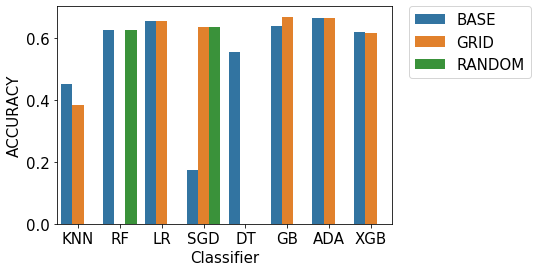

In [104]:
#create a histogram of the output
ax = sns.barplot(x="classifier", y="accuracy", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('ACCURACY', fontsize = 15)
ax.tick_params(labelsize=15)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

In [105]:
#show results in form of chart
df_results_base = pd.DataFrame({'classifier':['KNN',
                                         'RF',
                                         'LR',
                                         'SGD',
                                         'DT',
                                         'GB',
                                        'ADA',
                                        'XGB'],
                           'data_set':['BASE']*8,
                
                          'accuracy':[knn_base_results,
                                      base_rf_results,
                                      base_lr_results,
                                      sgdc_base_results,
                                      tree_base_results,
                                      gbc_base_results,
                                      ada_base_results ,
                                      xgb_base_results,]
                          })

In [106]:
#print results in form of table
df_results_base

,classifier,data_set,accuracy
0,KNN,BASE,0.452085
1,RF,BASE,0.627712
2,LR,BASE,0.655365
3,SGD,BASE,0.174009
4,DT,BASE,0.555049
5,GB,BASE,0.639479
6,ADA,BASE,0.665809
7,XGB,BASE,0.619328


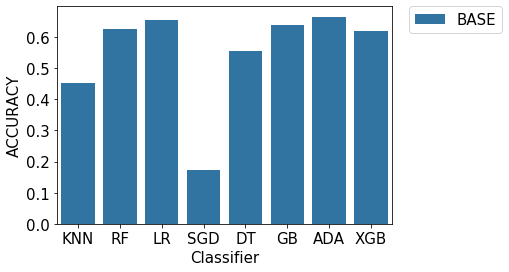

In [107]:
#create a histogram of the output
ax = sns.barplot(x="classifier", y="accuracy", hue="data_set", data=df_results_base)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('ACCURACY', fontsize = 15)
ax.tick_params(labelsize=15)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

In [108]:
#claculate error in knn model
error = []

# Calculating error for K values between 1 and 40
for i in range(700, 800):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_tf, y_train_tf)
    pred_i = knn.predict(X_test_tf)
    error.append(np.mean(pred_i != y_test_tf))

Text(0, 0.5, 'Mean Error')

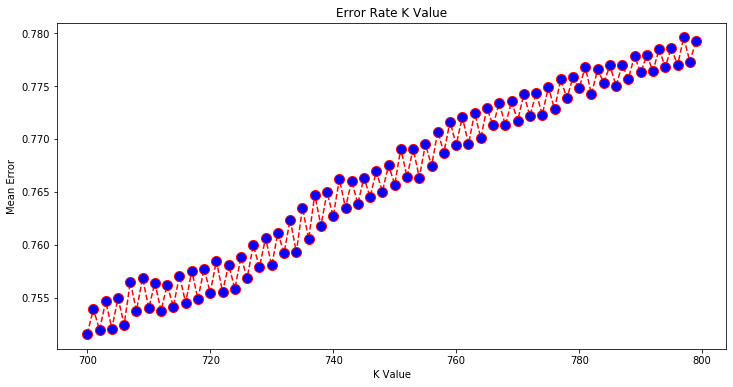

In [109]:
#plot dig for errors in knn
plt.figure(figsize=(12, 6))
plt.plot(range(700, 800), error, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')